In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import os
import gzip
import csv

import pandas as pd
import numpy as np

import pexpect
import time

from datetime import datetime
import pytz

import matplotlib.pyplot as plt

### Query data from opensky

Create a local file called `auth.py` that contains

```
user='YourName'
password='YourPassword'
```

And don't put that file in your repo!

In [3]:
from auth import *
user

'AllenDowney'

In [4]:
query1 = ("SELECT * FROM state_vectors_data4 WHERE "
         "icao24='a0d724' AND "
         "time>=1480760100 AND time<=1480764600 AND "
         "hour>=1480759200 AND hour<=1480762800;")

query2 = ("SELECT * FROM state_vectors_data4 WHERE "
         "lat>=42.33 AND lat<=42.41 AND "
         "lon>=-71.07 AND lon<=-70.95 AND "
         "hour>=1480759200 AND hour<=1480762800;")

'SELECT * FROM state_vectors_data4 WHERE lat>=42.33 AND lat<=42.41 AND lon>=-71.07 AND lon<=-70.95 AND hour>=1480759200 AND hour<=1480762800;'

In [5]:
def use_pexpect(query):
    cmd = 'ssh -p 2230 -l AllenDowney data.opensky-network.org'
    pex = pexpect.spawn(cmd)
    pex.expect ("AllenDowney@data.opensky-network.org's password:")
    time.sleep(0.1)
    pex.sendline(password)
    pex.expect('\[hadoop-1:21000\] > ')
    pex.sendline(query)
    pex.expect('\[hadoop-1:21000\] > ', timeout=300)
    result = pex.before
    pex.sendline('quit;')
    pex.close()
    return result

In [6]:
result = use_pexpect(query1);

In [7]:
len(result)

757740

In [8]:
type(result)

bytes

In [9]:
def write_file(result, filename):
    with open(filename, 'wb') as f:
        f.write(result)

"Our exact site is at 11 Hale Ave, Winthrop, MA (42°21'39.2"N 70°58'18.9"W; 42.360897, -70.971921). We expect aircraft to land directly over Coughlin Park and the water just to the East, passing directly through the lat/long (42°21'43.2"N 70°58'19.0"W; 42.362000, -70.971942). I think if we were to make a 0.5 km radius around that spot, we'd catch all of the aircraft taking off and landing through our site. And if we could pull descent trajectories for +/- 15 s of passing our site (1 Hz lat/long/altitude for each aircraft), tail numbers (and aircraft types), that would be rich for our analysis."

In [10]:
template = ("SELECT * FROM state_vectors_data4 WHERE "
            "icao24='a33a1d' AND "
            "lat>=42.33 AND lat<=42.41 AND "
            "lon>=-71.07 AND lon<=-70.95 AND "
            "hour>=%d AND hour<%d;")

template2 = ('SELECT * FROM state_vectors_data4 WHERE '
             'callsign="%s" AND '
             'hour>=%d AND hour<%d;')

template3 = ('SELECT * FROM state_vectors_data4 WHERE '
             'icao24="%s" AND '
             'hour>=%d AND hour<%d;')

'SELECT * FROM state_vectors_data4 WHERE icao24="%s" AND hour>=%d AND hour<%d;'

In [11]:
def make_query(start, end):
    """Select traffic through a lat-lon square.
    """
    ts1 = start.timestamp()
    ts2 = end.timestamp()
    return template % (ts1, ts2)

In [12]:
def make_query2(callsign, start, end):
    """Select trajectory by callsign.
    """
    ts1 = start.timestamp()
    ts2 = end.timestamp()
    return template2 % (callsign, ts1, ts2)

In [13]:
def make_query3(icao24, start, end):
    """Select trajectory by icao24.
    """
    ts1 = start.timestamp()
    ts2 = end.timestamp()
    return template3 % (icao24, ts1, ts2)

In [14]:
start = datetime(2017, 8, 31, 0, 0, 0)
end = datetime(2017, 8, 31, 23, 59, 59)

datetime.datetime(2017, 8, 31, 23, 59, 59)

In [15]:
eastern = pytz.timezone('US/Eastern')
start = eastern.localize(start)
end = eastern.localize(end)

datetime.datetime(2017, 8, 31, 23, 59, 59, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

In [16]:
fmt = '%Y-%m-%d %H:%M:%S %Z%z'
print(start.strftime(fmt))
print(end.strftime(fmt))

2017-08-31 00:00:00 EDT-0400
2017-08-31 23:59:59 EDT-0400


In [17]:
query = make_query(start, end)

"SELECT * FROM state_vectors_data4 WHERE icao24='a33a1d' AND lat>=42.33 AND lat<=42.41 AND lon>=-71.07 AND lon<=-70.95 AND hour>=1504152000 AND hour<1504238399;"

In [18]:
query2 = make_query2('JBU390', start, end)

'SELECT * FROM state_vectors_data4 WHERE callsign="JBU390" AND hour>=1504152000 AND hour<1504238399;'

In [19]:
query3 = make_query3('a33a1d', start, end)

'SELECT * FROM state_vectors_data4 WHERE icao24="a33a1d" AND hour>=1504152000 AND hour<1504238399;'

In [20]:
result = use_pexpect(query3);
len(result)

5303173

In [21]:
result[:1000]

b'SELECT * FROM state_vectors_data4 WHERE icao24="a33a1d" AND ho\rour>=1504152000 AND hour<1504238399;\r\n+------------+--------+-------------------+--------------------+-------------------+-------------------+-------------------+----------+----------+-------+-------+--------+-------------------+-------------------+----------------+----------------+------------+\r\n| time       | icao24 | lat               | lon                | velocity          | heading           | vertrate          | callsign | onground | alert | spi   | squawk | baroaltitude      | geoaltitude       | lastposupdate  | lastcontact    | hour       |\r\n+------------+--------+-------------------+--------------------+-------------------+-------------------+-------------------+----------+----------+-------+-------+--------+-------------------+-------------------+----------------+----------------+------------+\r\n| 1504210377 | a33a1d | 34.44419860839844 | -78.88250856983416 | 243.3673570651208 | 10.59733514502356 | 6.8

In [22]:
def write_file(result, filename):
    with open(filename, 'wb') as f:
        f.write(result)

In [23]:
filename = 'openskies_logan_2017-08-31.csv'
write_file(result, filename)

In [24]:
from io import StringIO

def clean_csv(filename):
    res = StringIO()
    with open(filename) as f:
        for line in f:
            if line.startswith('| time'):
                continue
            if line.startswith('|'):
                line = line.strip('|').replace(' ', '')
                res.write(line)
    res.seek(0)
    return res

In [25]:
names = ['time', 'icao24', 'lat', 'lon', 'velocity', 'heading', 'vertrate',
       'callsign', 'onground', 'alert', 'spi', 'squawk', 'baroaltitude',
       'geoaltitude', 'lastposupdate', 'lastcontact', 'hour', 'Unnamed: 17']

cleaned = clean_csv(filename)
df = pd.read_csv(cleaned, sep='|', names=names, header=None)
df.columns = ['time', 'icao24', 'lat', 'lon', 'velocity', 'heading', 'vertrate',
       'callsign', 'onground', 'alert', 'spi', 'squawk', 'baroaltitude',
       'geoaltitude', 'lastposupdate', 'lastcontact', 'hour', 'Unnamed: 17']

In [26]:
df.index = df.time
df.sort_index(inplace=True)

In [27]:
df.head()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,hour,Unnamed: 17
time,,,,,,,,,,,,,,,,,,
1504173759,1504173759,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,167.64,NaN,NaN,1.504174e+09,1504173600,NaN
1504173760,1504173760,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,175.26,NaN,NaN,1.504174e+09,1504173600,NaN
1504173761,1504173761,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,175.26,NaN,NaN,1.504174e+09,1504173600,NaN
1504173762,1504173762,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,213.36,NaN,NaN,1.504174e+09,1504173600,NaN
1504173763,1504173763,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,228.60,NaN,NaN,1.504174e+09,1504173600,NaN


In [28]:
df.tail()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,hour,Unnamed: 17
time,,,,,,,,,,,,,,,,,,
1504238395,1504238395,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,2675.0,6347.46,NaN,NaN,1.504238e+09,1504234800,NaN
1504238396,1504238396,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,2675.0,6347.46,NaN,NaN,1.504238e+09,1504234800,NaN
1504238397,1504238397,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,2675.0,6347.46,NaN,NaN,1.504238e+09,1504234800,NaN
1504238398,1504238398,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,2675.0,6355.08,NaN,NaN,1.504238e+09,1504234800,NaN
1504238399,1504238399,a33a1d,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,2675.0,6355.08,NaN,NaN,1.504238e+09,1504234800,NaN


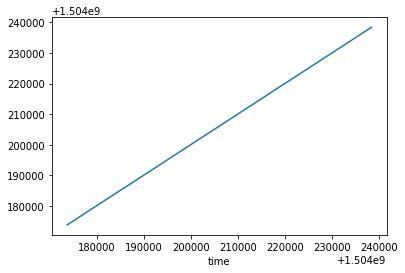

In [29]:
df.time.plot()

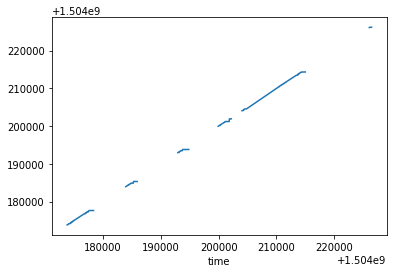

In [30]:
df.lastposupdate.plot()

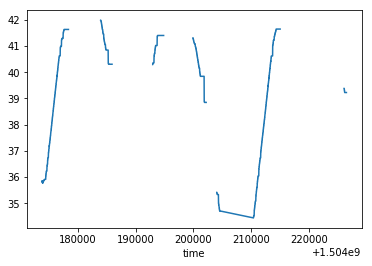

In [31]:
df.lat.plot()

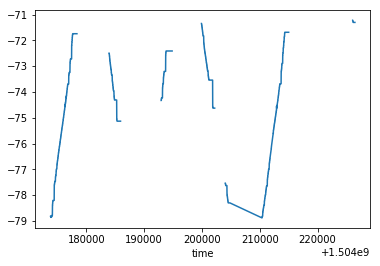

In [32]:
df.lon.plot()

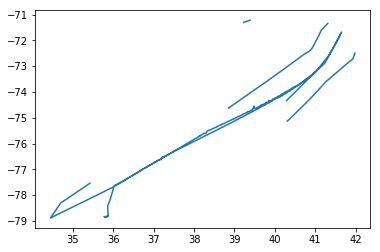

In [33]:
import matplotlib.pyplot as plt
plt.plot(df.lat, df.lon)

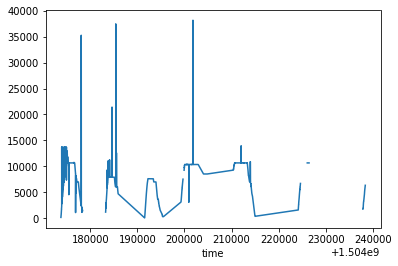

In [34]:
df.baroaltitude.plot()

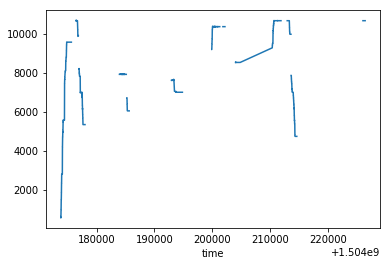

In [35]:
df.geoaltitude.plot()

In [36]:
from cartopy.feature import NaturalEarthFeature
from cartopy.crs import PlateCarree, EuroPP

countries = NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    edgecolor='#524c50',
    facecolor='none',
    alpha=.5)


In [37]:
extent = [np.nanmin(df.lon), np.nanmax(df.lon), np.nanmin(df.lat), np.nanmax(df.lat)]

[-78.88250856983416, -71.22052001953125, 34.444198608398445, 41.98260498046875]

/home/downey/anaconda3/envs/FlightData/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


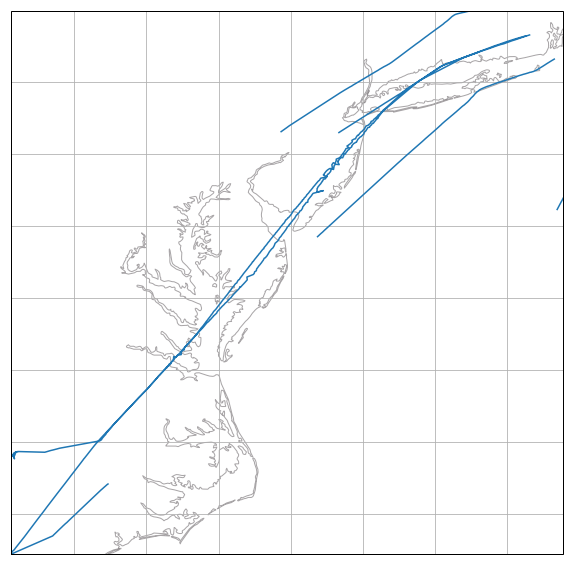

In [38]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=PlateCarree())

ax.add_feature(countries)
ax.gridlines()
ax.set_extent(extent)

ax.plot(df.lon, df.lat, transform=PlateCarree())

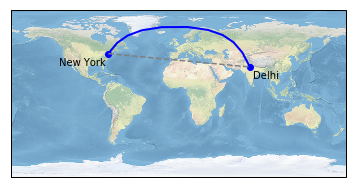

In [39]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

ny_lon, ny_lat = -75, 43
delhi_lon, delhi_lat = 77.23, 28.61

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.plot([ny_lon, delhi_lon], [ny_lat, delhi_lat],
         color='gray', linestyle='--',
         transform=ccrs.PlateCarree(),
         )

plt.text(ny_lon - 3, ny_lat - 12, 'New York',
         horizontalalignment='right',
         transform=ccrs.Geodetic())

plt.text(delhi_lon + 3, delhi_lat - 12, 'Delhi',
         horizontalalignment='left',
         transform=ccrs.Geodetic())

plt.show()

In [40]:
df.icao24.unique()

array(['a33a1d'], dtype=object)

In [41]:
for name, group in df.groupby('icao24'):
    min_alt = group.baroaltitude.min()
    print(name, min_alt)

a33a1d 68.58
